In [ ]:
!pip install scikit-learn==1.0.2


[0]	validation_0-mlogloss:1.56285
[1]	validation_0-mlogloss:1.51523
[2]	validation_0-mlogloss:1.46873
[3]	validation_0-mlogloss:1.42726
[4]	validation_0-mlogloss:1.39102
[5]	validation_0-mlogloss:1.35361
[6]	validation_0-mlogloss:1.32103
[7]	validation_0-mlogloss:1.28294
[8]	validation_0-mlogloss:1.25097
[9]	validation_0-mlogloss:1.21668
[10]	validation_0-mlogloss:1.18420
[11]	validation_0-mlogloss:1.15578
[12]	validation_0-mlogloss:1.12578
[13]	validation_0-mlogloss:1.10014
[14]	validation_0-mlogloss:1.07286
[15]	validation_0-mlogloss:1.04508
[16]	validation_0-mlogloss:1.02589
[17]	validation_0-mlogloss:1.00501
[18]	validation_0-mlogloss:0.98222
[19]	validation_0-mlogloss:0.96017
[20]	validation_0-mlogloss:0.93964
[21]	validation_0-mlogloss:0.91764
[22]	validation_0-mlogloss:0.90023
[23]	validation_0-mlogloss:0.87983
[24]	validation_0-mlogloss:0.86321
[25]	validation_0-mlogloss:0.84879
[26]	validation_0-mlogloss:0.82915
[27]	validation_0-mlogloss:0.81432
[28]	validation_0-mlogloss:0.7

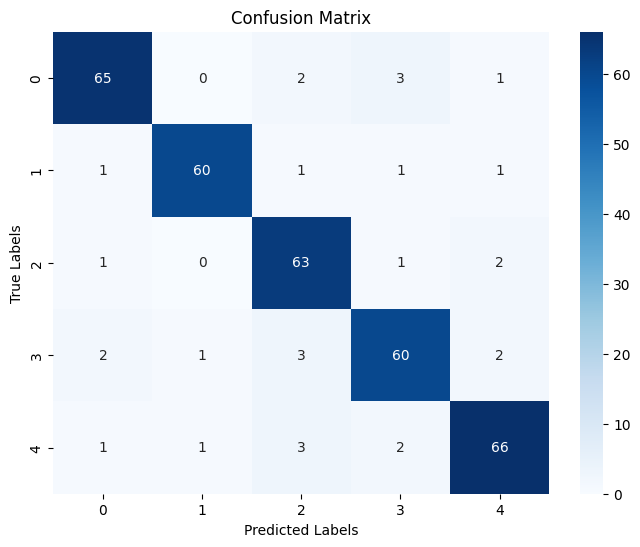


False Negative Rates for Each Class:
Class 0: FNR = 0.08
Class 1: FNR = 0.06
Class 2: FNR = 0.06
Class 3: FNR = 0.12
Class 4: FNR = 0.10

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92        71
           1       0.97      0.94      0.95        64
           2       0.88      0.94      0.91        67
           3       0.90      0.88      0.89        68
           4       0.92      0.90      0.91        73

    accuracy                           0.92       343
   macro avg       0.92      0.92      0.92       343
weighted avg       0.92      0.92      0.92       343



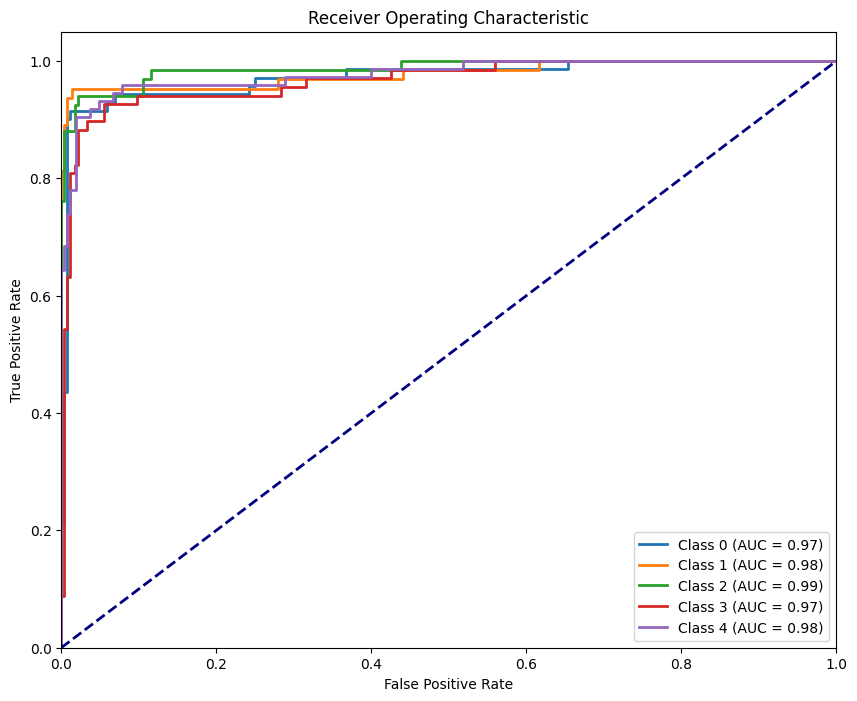

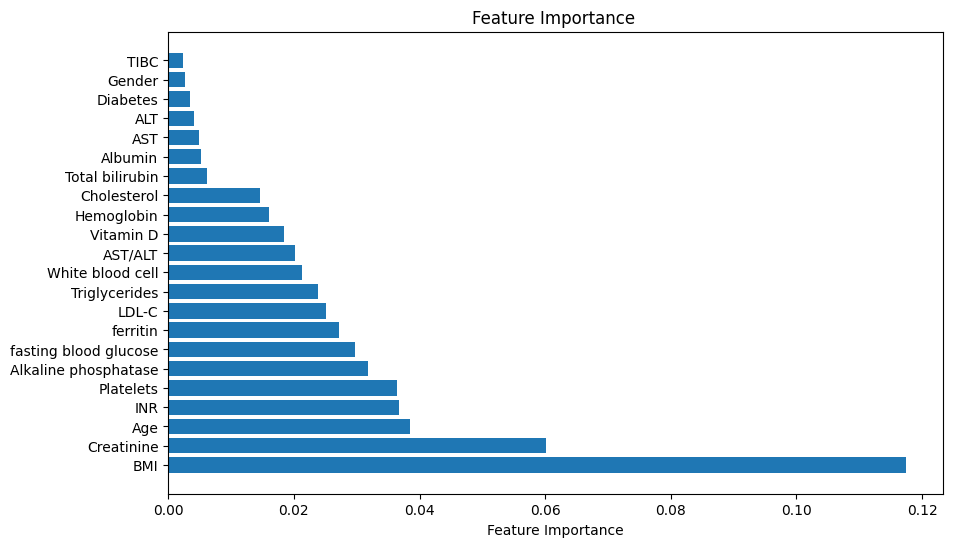

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Load training dataset
data = pd.read_excel('/content/augmented_train_data_noise_1.xlsx')
data.fillna(data.mean(numeric_only=True), inplace=True)

# Load external test dataset
test_data_from_file = pd.read_excel('/content/test_data_1.xlsx')
test_data_from_file.fillna(test_data_from_file.mean(numeric_only=True), inplace=True)

# Splitting features and target
X = data.drop('steato score', axis=1)
y = data['steato score']

# Split the data into training and internal testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine internal test and external test data
X_test_combined = pd.concat([X_test_temp, test_data_from_file.drop('steato score', axis=1)], axis=0)
y_test_combined = pd.concat([y_test_temp, test_data_from_file['steato score']], axis=0)

# Define model
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,

)

# Set up parameters for GridSearchCV
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [ 3, 4],
    'n_estimators': [100, 200],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.6, 0.7],
    'reg_alpha': [1, 2],
    'reg_lambda': [0.5, 1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Get best model from GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Validation data for early stopping
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# Training with early stopping
best_xgb_model.fit(
    X_train_split,
    y_train_split,
    eval_set=[(X_val_split, y_val_split)]
)

# Check accuracy on test set
train_acc = best_xgb_model.score(X_train, y_train)
test_acc = best_xgb_model.score(X_test_combined, y_test_combined)
real_test_acc = best_xgb_model.score(test_data_from_file.drop('steato score', axis=1), test_data_from_file['steato score'])

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}")
print(f"Real Testing Accuracy: {real_test_acc:.2f}")

# Evaluation on combined test data
y_test_pred_combined = best_xgb_model.predict(X_test_combined)
y_test_prob_combined = best_xgb_model.predict_proba(X_test_combined)

# Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

cm_combined = confusion_matrix(y_test_combined, y_test_pred_combined)
classes = np.unique(y_test_combined)
plot_confusion_matrix(cm_combined, classes)

# False Negative Rate for each class
fn_rate_per_class = []
for i in range(len(cm_combined)):
    FN = sum(cm_combined[i, :]) - cm_combined[i, i]
    TP = cm_combined[i, i]
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0
    fn_rate_per_class.append(FNR)

# Print FNR for each class
print("\nFalse Negative Rates for Each Class:")
for i, fnr in enumerate(fn_rate_per_class):
    print(f"Class {classes[i]}: FNR = {fnr:.2f}")

# Classification Report
report = classification_report(y_test_combined, y_test_pred_combined, target_names=classes.astype(str))
print("\nClassification Report:\n", report)

# ROC Curve
plt.figure(figsize=(10, 8))
for i, cls in enumerate(best_xgb_model.classes_):
    fpr, tpr, _ = roc_curve((y_test_combined == cls).astype(int), y_test_prob_combined[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[cls]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_xgb_model, X_test_combined, y_test_combined, n_repeats=10, random_state=42)
importance_scores = perm_importance.importances_mean
sorted_idx_perm = np.argsort(importance_scores)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx_perm], importance_scores[sorted_idx_perm])
plt.xlabel('Feature Importance')
plt.title('Feature Importance ')
plt.show()


Top Features for Class 0 based on predict_proba:
ALT: 0.0015
White blood cell: 0.0006
Albumin: 0.0006
AST/ALT: -0.0003
Diabetes: -0.0003
AST: -0.0009
Total bilirubin: -0.0009
Hemoglobin: -0.0012
TIBC: -0.0020
Gender: -0.0023
Triglycerides: -0.0038
ferritin: -0.0061
Cholesterol: -0.0064
LDL-C: -0.0064
fasting blood glucose: -0.0067
Vitamin D: -0.0070
INR: -0.0082
Alkaline phosphatase: -0.0082
Age: -0.0093
Creatinine: -0.0120
Platelets: -0.0152
BMI: -0.0257


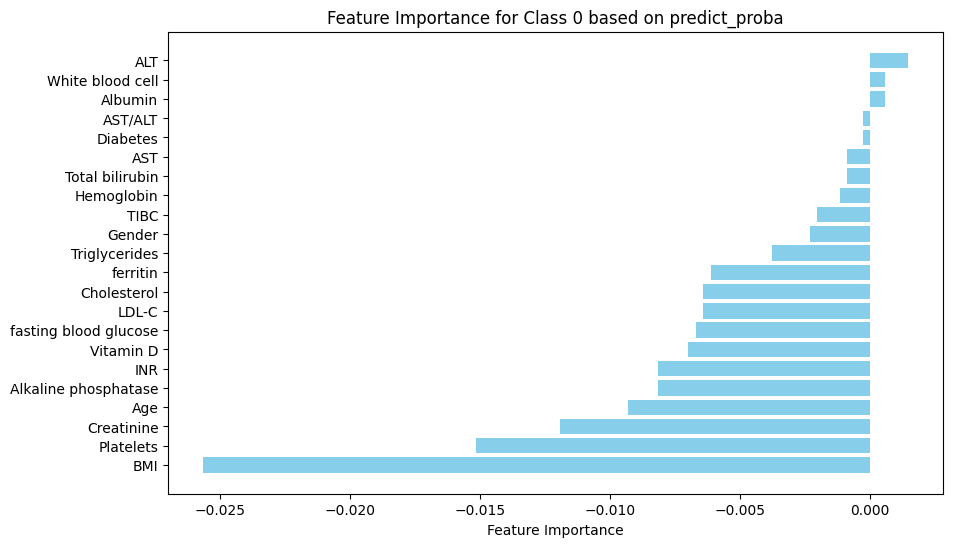


Top Features for Class 1 based on predict_proba:
INR: 0.0096
Triglycerides: 0.0070
Hemoglobin: 0.0052
White blood cell: 0.0044
Age: 0.0038
ALT: 0.0038
BMI: 0.0035
Diabetes: 0.0029
Albumin: 0.0029
TIBC: 0.0020
Vitamin D: 0.0009
Creatinine: 0.0009
fasting blood glucose: 0.0006
AST/ALT: 0.0003
Alkaline phosphatase: 0.0003
AST: -0.0000
Platelets: -0.0000
Total bilirubin: -0.0003
Gender: -0.0009
ferritin: -0.0026
Cholesterol: -0.0044
LDL-C: -0.0055


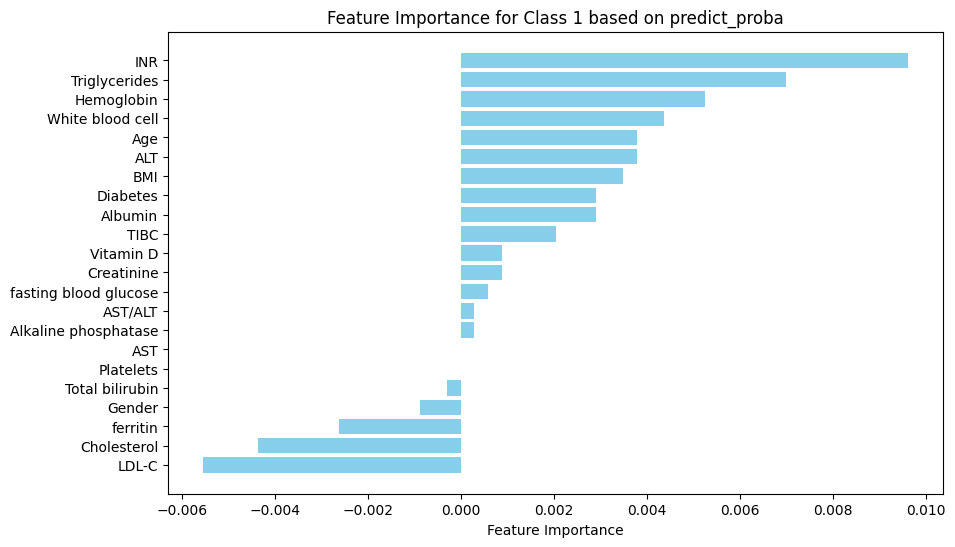


Top Features for Class 2 based on predict_proba:
Creatinine: 0.0085
Hemoglobin: 0.0067
Age: 0.0067
Triglycerides: 0.0061
Albumin: 0.0050
BMI: 0.0041
ALT: 0.0038
White blood cell: 0.0035
fasting blood glucose: 0.0029
TIBC: 0.0020
Vitamin D: 0.0020
AST: 0.0020
Gender: 0.0017
AST/ALT: 0.0012
Total bilirubin: 0.0003
Diabetes: 0.0003
LDL-C: -0.0000
Cholesterol: -0.0003
INR: -0.0015
Platelets: -0.0017
ferritin: -0.0044
Alkaline phosphatase: -0.0076


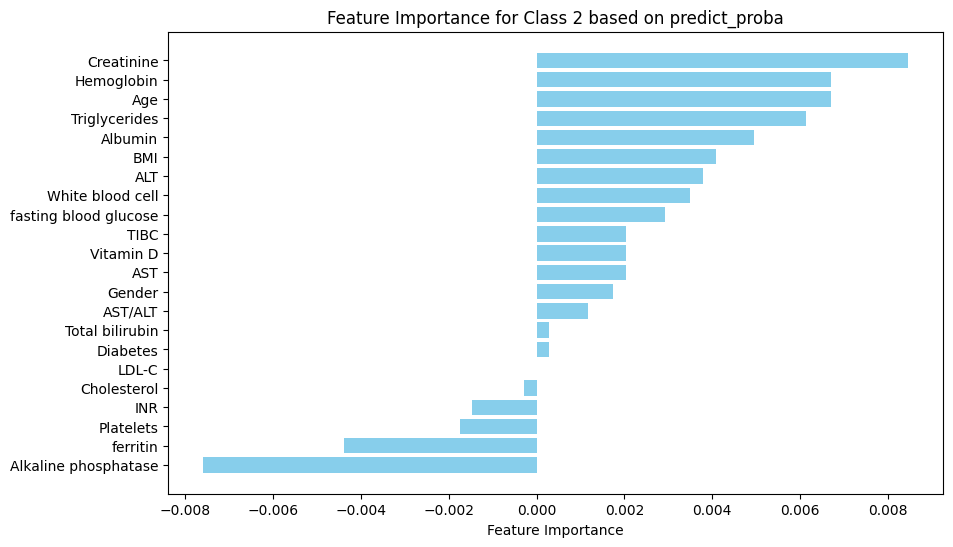


Top Features for Class 3 based on predict_proba:
Triglycerides: 0.0105
BMI: 0.0102
Age: 0.0061
Hemoglobin: 0.0050
White blood cell: 0.0029
TIBC: 0.0017
Creatinine: 0.0017
ALT: 0.0015
Albumin: 0.0012
fasting blood glucose: 0.0012
Total bilirubin: -0.0003
AST/ALT: -0.0003
Diabetes: -0.0009
Gender: -0.0012
Vitamin D: -0.0017
ferritin: -0.0017
AST: -0.0026
Platelets: -0.0047
INR: -0.0064
LDL-C: -0.0082
Cholesterol: -0.0085
Alkaline phosphatase: -0.0087


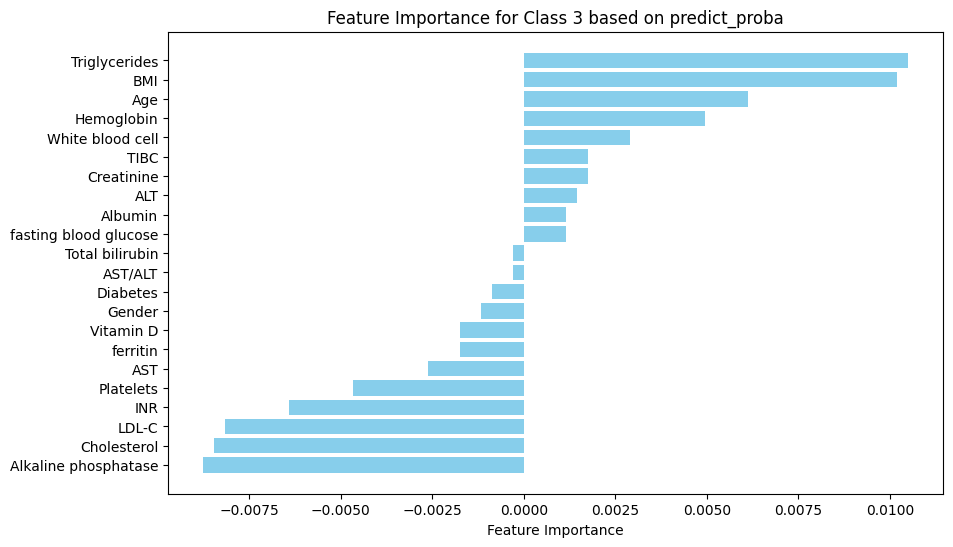


Top Features for Class 4 based on predict_proba:
BMI: 0.0207
Triglycerides: 0.0082
Age: 0.0079
Hemoglobin: 0.0058
White blood cell: 0.0052
ALT: 0.0047
ferritin: 0.0044
fasting blood glucose: 0.0038
AST/ALT: 0.0029
Creatinine: 0.0029
TIBC: 0.0020
Albumin: 0.0020
Vitamin D: 0.0009
Total bilirubin: 0.0000
AST: 0.0000
Diabetes: -0.0003
Gender: -0.0009
Platelets: -0.0015
INR: -0.0017
Alkaline phosphatase: -0.0017
Cholesterol: -0.0020
LDL-C: -0.0044


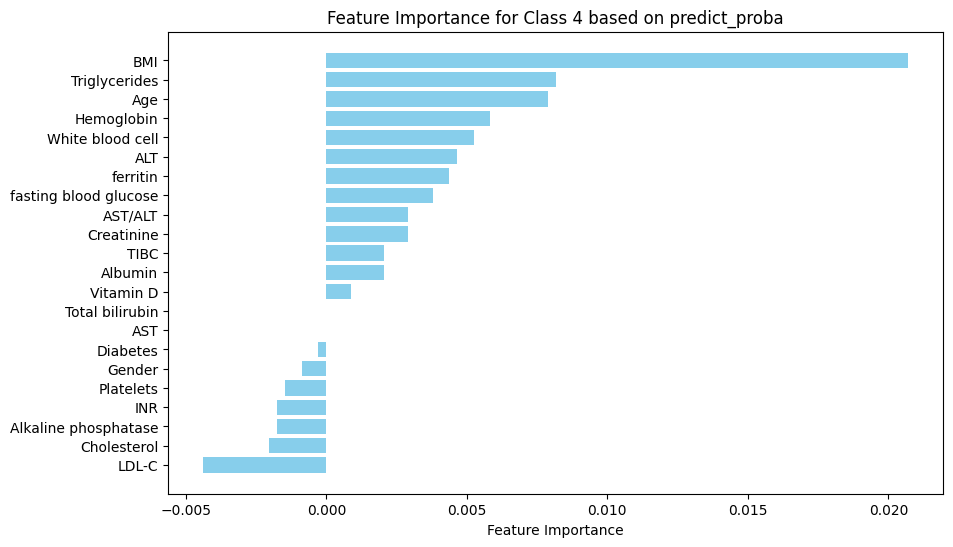

In [ ]:
from sklearn.inspection import permutation_importance

# Feature Importance for each class separately using predict_proba
feature_importances_per_class_proba = {}

# Loop over each class in the model
for class_index, cls in enumerate(best_xgb_model.classes_):
    # Binary target for the current class
    y_binary = (y_test_combined == cls).astype(int)

    # Get predicted probabilities for the current class
    y_pred_proba = best_xgb_model.predict_proba(X_test_combined)[:, class_index]

    # Calculate feature importance based on predict_proba
    importance_scores = permutation_importance(best_xgb_model, X_test_combined, y_binary,
                                               scoring='accuracy', n_repeats=10, random_state=42).importances_mean

    # Sort by importance (descending)
    sorted_idx = np.argsort(importance_scores)[::-1]
    sorted_features = np.array(X.columns)[sorted_idx]
    sorted_scores = importance_scores[sorted_idx]

    # Print important features for the class
    print(f"\nTop Features for Class {cls} based on predict_proba:")
    for feature, score in zip(sorted_features, sorted_scores):
        print(f"{feature}: {score:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_scores, color='skyblue')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for Class {cls} based on predict_proba')
    plt.show()
